# Venmo Transaction with Text and Social Network Analysis


### __1. Text Analytics__

#### 1.1 Explore the dataset

In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=e651258dd4bea268285b1c3b06843e09a0c5bfbbf267afec3361082e31026f6d
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
# import packages
import re
import pandas as pd
from google.colab import drive
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit, col, udf, explode, array_contains, split, size, array_union
from pyspark.sql.types import ArrayType, StringType

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Create a Spark session
spark = SparkSession.builder \
    .appName("VenmoSample") \
    .getOrCreate()

In [5]:
# Path to the file
parquet_file_path = '/content/drive/Shared drives/423/HW5/VenmoSample.snappy.parquet'

# Read the Parquet file into a DataFrame
data = spark.read.parquet(parquet_file_path)
data.show(5)

+-------+-------+----------------+-------------------+------------+-----------+--------------------+
|  user1|  user2|transaction_type|           datetime| description|is_business|            story_id|
+-------+-------+----------------+-------------------+------------+-----------+--------------------+
|1218774|1528945|         payment|2015-11-27 10:48:19|        Uber|      false|5657c473cd03c9af2...|
|5109483|4782303|         payment|2015-06-17 11:37:04|      Costco|      false|5580f9702b64f70ab...|
|4322148|3392963|         payment|2015-06-19 07:05:31|Sweaty balls|      false|55835ccb1a624b14a...|
| 469894|1333620|          charge|2016-06-03 23:34:13|          🎥|      false|5751b185cd03c9af2...|
|2960727|3442373|         payment|2016-05-29 23:23:42|           ⚡|      false|574b178ecd03c9af2...|
+-------+-------+----------------+-------------------+------------+-----------+--------------------+
only showing top 5 rows



In [6]:
# Load the word classification dictionary
word_dict_path = "/content/drive/Shared drives/423/HW5/Venmo Word Classification Dictionary BAX-423 - Word_Dict.csv"
word_dict_df = spark.read.option("header", "true").csv(word_dict_path)
word_dict_df.show(5)

+----------+---------+---------+--------+------+--------------+-----------+-----+---------------+---------+
|    People|     Food|    Event|Activity|Travel|Transportation|    Utility| Cash|Illegal/Sarcasm|@dropdown|
+----------+---------+---------+--------+------+--------------+-----------+-----+---------------+---------+
|    friend|     food| birthday|    ball| beach|          lyft|       bill| atm |      addiction|     NULL|
|friendship|      bbq|christmas|    boat| place|          uber|      cable|bank |           drug|     NULL|
|      baby|     bean|    happy|     bar|    la|           cab|        fee|cash |          wangs|     NULL|
|       boy|    latte|     bday|    book| world|           bus|   electric|money|           weed|     NULL|
|      girl|breakfast|  wedding|    club| hotel|           car|electricity| buck|           anal|     NULL|
+----------+---------+---------+--------+------+--------------+-----------+-----+---------------+---------+
only showing top 5 rows



In [7]:
# Load the emoji classification dictionary
emoji_dict_path = "/content/drive/Shared drives/423/HW5/Venmo_Emoji_Classification_Dictionary.csv"
emoji_dict_df = spark.read.option("header", "true").csv(emoji_dict_path)
emoji_dict_df.show(5)

+-----+------+----+--------+--------------+------+-------+
|Event|Travel|Food|Activity|Transportation|People|Utility|
+-----+------+----+--------+--------------+------+-------+
| 🇦🇺|    🏔|  🍇|      👾|            🚄|    😀|      ⚡|
| 🇫🇷|     ⛰|  🍈|      🕴|            🚅|    😃|     💡|
|   🎂|    🌋|  🍉|      🎪|            🚆|    😄|     🔌|
|   🛍|    🗻|  🍊|      🎭|            🚇|    😁|     📺|
| 🇨🇦|    🏕|  🍋|      🎨|            🚈|    😆|     🔌|
+-----+------+----+--------+--------------+------+-------+
only showing top 5 rows



#### 1.2 Add 10 words to the dictionary

In [8]:
# List of new words added
new_words = [
    ("mate", "People"),
    ("conference", "Event"),
    ("festival", "Event"),
    ("reunion", "Event"),
    ("reading", "Activity"),
    ("gaming", "Activity"),
    ("scooter", "Transportation"),
    ("cheque", "Cash"),
    ("transfer", "Cash"),
    ("fraud", "Illegal/Sarcasm")
]

In [9]:
# Define the schema of the existing dictionary
schema = word_dict_df.schema

# Create a DataFrame with only the necessary columns
new_words_df = spark.createDataFrame(new_words, ["Word", "Category"])

# Create a DataFrame with the full schema, filling missing columns with null values
for field in schema:
    if field.name not in new_words_df.columns:
        new_words_df = new_words_df.withColumn(field.name, lit(None).cast(field.dataType))

# Append new words to the existing dictionary
word_dict_df = word_dict_df.union(new_words_df.select(schema.names))

In [10]:
print(word_dict_df.head(5))

[Row(People='friend', Food='food', Event='birthday', Activity='ball', Travel='beach', Transportation='lyft', Utility='bill', Cash='atm ', Illegal/Sarcasm='addiction', @dropdown=None), Row(People='friendship', Food='bbq', Event='christmas', Activity='boat', Travel='place', Transportation='uber', Utility='cable', Cash='bank ', Illegal/Sarcasm='drug', @dropdown=None), Row(People='baby', Food='bean', Event='happy', Activity='bar', Travel='la', Transportation='cab', Utility='fee', Cash='cash ', Illegal/Sarcasm='wangs', @dropdown=None), Row(People='boy', Food='latte', Event='bday', Activity='book', Travel='world', Transportation='bus', Utility='electric', Cash='money', Illegal/Sarcasm='weed', @dropdown=None), Row(People='girl', Food='breakfast', Event='wedding', Activity='club', Travel='hotel', Transportation='car', Utility='electricity', Cash='buck', Illegal/Sarcasm='anal', @dropdown=None)]


#### 1.3 Classify Venmo’s transactions

In [11]:
# Preprocess the Data (separate the emojis & text)
def extract_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    return emoji_pattern.findall(text)

def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F1E0-\U0001F1FF"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

extract_emojis_udf = udf(extract_emojis, ArrayType(StringType()))
remove_emojis_udf = udf(remove_emojis, StringType())

data = data.withColumn("emojis", extract_emojis_udf(col("description")))
data = data.withColumn("text", remove_emojis_udf(col("description")))

In [13]:
# reload them in pandas
emoji_dict_df = pd.read_csv(emoji_dict_path)
word_dict_df = pd.read_csv(word_dict_path)

# Create dictionaries for lookup
emoji_category_dict = {emoji: category for category in emoji_dict_df.columns for emoji in emoji_dict_df[category].dropna()}
word_category_dict = {word: category for category in word_dict_df.columns for word in word_dict_df[category].dropna()}

def classify_emojis(emojis):
    categories = [emoji_category_dict.get(e) for e in emojis]
    return [c for c in categories if c is not None]

def classify_words(text):
    words = text.split()
    categories = [word_category_dict.get(w) for w in words]
    return [c for c in categories if c is not None]

classify_emojis_udf = udf(classify_emojis, ArrayType(StringType()))
classify_words_udf = udf(classify_words, ArrayType(StringType()))

data = data.withColumn("emoji_categories", classify_emojis_udf(col("emojis")))
data = data.withColumn("word_categories", classify_words_udf(col("text")))


In [15]:
# Percentage of emoji-only transactions
emoji_only = data.filter((col("text") == "") & (size(col("emojis")) > 0))
emoji_only_percentage = emoji_only.count() / data.count() * 100
print(f"Percentage of emoji-only transactions: {emoji_only_percentage}%")

# Top 5 most popular emojis
top_5_emojis = data.select(explode(col("emojis")).alias("emoji")).groupBy("emoji").count().orderBy("count", ascending=False).limit(5)
top_5_emojis.show()

# Top 3 most popular emoji categories
top_3_emoji_categories = data.select(explode(col("emoji_categories")).alias("category")).groupBy("category").count().orderBy("count", ascending=False).limit(3)
top_3_emoji_categories.show()

Percentage of emoji-only transactions: 21.418004461322763%
+-----+-----+
|emoji|count|
+-----+-----+
|   🍕|68011|
|   🍻|54386|
|   🍴|38437|
| 🏠💸|35380|
|   🍺|33300|
+-----+-----+

+--------+------+
|category| count|
+--------+------+
|    Food|494365|
|  People|311015|
|Activity|123049|
+--------+------+



#### 1.4 Explore user's static spending profile

In [16]:
data = data.withColumn("combined_categories", array_union(col("emoji_categories"), col("word_categories")))

In [17]:
data.show(5)

+-------+-------+----------------+-------------------+------------+-----------+--------------------+------+------------+----------------+-----------------+-------------------+
|  user1|  user2|transaction_type|           datetime| description|is_business|            story_id|emojis|        text|emoji_categories|  word_categories|combined_categories|
+-------+-------+----------------+-------------------+------------+-----------+--------------------+------+------------+----------------+-----------------+-------------------+
|1218774|1528945|         payment|2015-11-27 10:48:19|        Uber|      false|5657c473cd03c9af2...|    []|        Uber|              []|               []|                 []|
|5109483|4782303|         payment|2015-06-17 11:37:04|      Costco|      false|5580f9702b64f70ab...|    []|      Costco|              []|               []|                 []|
|4322148|3392963|         payment|2015-06-19 07:05:31|Sweaty balls|      false|55835ccb1a624b14a...|    []|Sweaty balls|

In [18]:
# Explode the combined_categories to get one category per row
exploded_data = data.select("user1", explode(col("combined_categories")).alias("category"))
exploded_data.show()

+-------+---------------+
|  user1|       category|
+-------+---------------+
|4322148|Illegal/Sarcasm|
| 469894|          Event|
|3766386|        Utility|
|1134661|         People|
|4238868|           Food|
|3625798|         People|
|3625798|           Cash|
|3625798|Illegal/Sarcasm|
| 613908| Transportation|
| 656477|        Utility|
|6222232|        Utility|
| 367859|        Utility|
|7533517|       Activity|
|6530112|        Utility|
|1391021|           Food|
|2178055|       Activity|
|2178055|        Utility|
| 444145|       Activity|
|5696834|       Activity|
|4351351|         People|
+-------+---------------+
only showing top 20 rows



In [19]:
# Group by user and category, and count the occurrences
user_category_count = exploded_data.groupBy("user1", "category").count()
user_category_count.show()

+-------+---------------+-----+
|  user1|       category|count|
+-------+---------------+-----+
| 412023|          Event|    1|
|2656348|         Travel|    1|
|1806527|        Utility|    6|
|5576940|        Utility|    1|
|5301509|           Food|    1|
| 377035|           Food|    3|
|2549578|       Activity|    2|
| 432599| Transportation|    1|
|1637274|         People|    1|
|2091723|           Food|    2|
| 826176|        Utility|    1|
|7952748|       Activity|    1|
|1347558|           Food|    2|
|1533205|        Utility|    1|
|2851121|Illegal/Sarcasm|    3|
| 151342| Transportation|    1|
|1243430|           Food|    1|
| 312006|       Activity|    1|
|2267289|        Utility|    1|
|3343832|       Activity|    2|
+-------+---------------+-----+
only showing top 20 rows



In [20]:
user_category_profile = user_category_count.groupBy("user1").pivot("category").sum("count")

In [21]:
user_category_profile.show()

+-------+--------+----+-----+----+---------------+------+--------------+------+-------+
|  user1|Activity|Cash|Event|Food|Illegal/Sarcasm|People|Transportation|Travel|Utility|
+-------+--------+----+-----+----+---------------+------+--------------+------+-------+
|2623417|       2|NULL| NULL|   1|              1|  NULL|          NULL|  NULL|      1|
| 286787|       2|NULL| NULL|NULL|           NULL|  NULL|          NULL|  NULL|   NULL|
|9434999|    NULL|NULL| NULL|   1|           NULL|     1|          NULL|  NULL|   NULL|
|3887649|    NULL|NULL| NULL|   2|              1|     2|          NULL|  NULL|   NULL|
|5630056|    NULL|   1| NULL|NULL|           NULL|     3|          NULL|  NULL|      2|
|2197256|    NULL|NULL| NULL|   1|           NULL|  NULL|          NULL|  NULL|   NULL|
|5524472|       1|NULL| NULL|   1|           NULL|  NULL|          NULL|  NULL|   NULL|
|7985491|    NULL|   1| NULL|NULL|           NULL|  NULL|          NULL|  NULL|      1|
| 597388|    NULL|NULL| NULL|   

In [22]:
# Fill NaN values with 0 for categories that are not present for a user
user_category_profile = user_category_profile.fillna(0)
user_category_profile.show()

+-------+--------+----+-----+----+---------------+------+--------------+------+-------+
|  user1|Activity|Cash|Event|Food|Illegal/Sarcasm|People|Transportation|Travel|Utility|
+-------+--------+----+-----+----+---------------+------+--------------+------+-------+
|2623417|       2|   0|    0|   1|              1|     0|             0|     0|      1|
| 286787|       2|   0|    0|   0|              0|     0|             0|     0|      0|
|9434999|       0|   0|    0|   1|              0|     1|             0|     0|      0|
|3887649|       0|   0|    0|   2|              1|     2|             0|     0|      0|
|5630056|       0|   1|    0|   0|              0|     3|             0|     0|      2|
|2197256|       0|   0|    0|   1|              0|     0|             0|     0|      0|
|5524472|       1|   0|    0|   1|              0|     0|             0|     0|      0|
|7985491|       0|   1|    0|   0|              0|     0|             0|     0|      1|
| 597388|       0|   0|    0|   

In [23]:
from pyspark.sql import functions as F

# Calculate the total number of transactions per user
total_transactions_per_user = user_category_count.groupBy("user1").agg(F.sum("count").alias("total_transactions"))

In [24]:
# Join total transactions with user category profile
user_category_profile = user_category_profile.join(total_transactions_per_user, on="user1")

In [25]:
# Calculate proportions

# Define the category columns
category_columns = ["Activity", "Cash", "Event", "Food", "Illegal/Sarcasm", "People", "Transportation", "Travel", "Utility"]

for category in category_columns:
    user_category_profile = user_category_profile.withColumn(category, (col(category) / col("total_transactions")))

# Drop the total_transactions column
user_category_profile = user_category_profile.drop("total_transactions")

In [26]:
# Show the result
user_category_profile.show(truncate=False)

+-----+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+
|user1|Activity           |Cash               |Event              |Food               |Illegal/Sarcasm    |People             |Transportation     |Travel            |Utility            |
+-----+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+
|3    |0.0                |0.0                |0.0                |0.5                |0.0                |0.5                |0.0                |0.0               |0.0                |
|12   |0.5                |0.0                |0.0                |0.0                |0.0                |0.0                |0.0                |0.0               |0.5                |
|13   |0.125              |0.0                |0.0625            

#### 1.5 Explore user's dynamic spending profile

Step 1: Create a Monthly Interval Column

In [27]:
from pyspark.sql import Window
from pyspark.sql.functions import col, min, datediff, months_between, year, month

# Convert datetime column to date type
data = data.withColumn("date", col("datetime").cast("date"))

# Find the first transaction date for each user
window_spec = Window.partitionBy("user1")
data = data.withColumn("first_date", min("date").over(window_spec))

# Calculate the number of months since the first transaction
data = data.withColumn("month", ((year(col("date")) - year(col("first_date"))) * 12 +
                       (month(col("date")) - month(col("first_date")))))

# Filter to only include the first 12 months
data = data.filter(col("month") <= 12)

Step 2: Classify Each Transaction into Categories

In [28]:
# Extract and classify emojis and text as before
data = data.withColumn("emojis", extract_emojis_udf(col("description")))
data = data.withColumn("text", remove_emojis_udf(col("description")))

data = data.withColumn("emoji_categories", classify_emojis_udf(col("emojis")))
data = data.withColumn("word_categories", classify_words_udf(col("text")))

# Combine classifications
data = data.withColumn("combined_categories", array_union(col("emoji_categories"), col("word_categories")))

Step 3: Calculate the Spending Profile for Each User at Each Month

In [29]:
# Explode the combined_categories to get one category per row
exploded_data = data.select("user1", "month", explode(col("combined_categories")).alias("category"))

# Group by user, month, and category, and count the occurrences
user_monthly_category_count = exploded_data.groupBy("user1", "month", "category").count()

# Pivot the data to get categories as columns
user_monthly_profile = user_monthly_category_count.groupBy("user1", "month").pivot("category").sum("count")

# Fill NaN values with 0 for categories that are not present for a user
user_monthly_profile = user_monthly_profile.fillna(0)

# Calculate the total number of transactions per user per month
total_transactions_per_user_month = user_monthly_category_count.groupBy("user1", "month").agg(F.sum("count").alias("total_transactions"))

# Join total transactions with user category profile
user_monthly_profile = user_monthly_profile.join(total_transactions_per_user_month, on=["user1", "month"])

# Calculate the proportion of each category
category_columns = [column for column in user_monthly_profile.columns if column not in ["user1", "month", "total_transactions"]]

# Calculate proportion
for category in category_columns:
    user_monthly_profile = user_monthly_profile.withColumn(category, col(category) / col("total_transactions"))

# Drop the total_transactions column
user_monthly_profile = user_monthly_profile.drop("total_transactions")

# Order by user and month
user_monthly_profile = user_monthly_profile.orderBy("user1", "month")

# Show the result
user_monthly_profile.show(truncate=False)

+-----+-----+--------+------------------+-----+----+------------------+------------------+--------------+------+-------+
|user1|month|Activity|Cash              |Event|Food|Illegal/Sarcasm   |People            |Transportation|Travel|Utility|
+-----+-----+--------+------------------+-----+----+------------------+------------------+--------------+------+-------+
|3    |0    |0.0     |0.0               |0.0  |0.0 |0.0               |1.0               |0.0           |0.0   |0.0    |
|3    |1    |0.0     |0.0               |0.0  |1.0 |0.0               |0.0               |0.0           |0.0   |0.0    |
|4    |0    |0.0     |0.0               |0.0  |0.5 |0.5               |0.0               |0.0           |0.0   |0.0    |
|11   |3    |0.0     |0.0               |1.0  |0.0 |0.0               |0.0               |0.0           |0.0   |0.0    |
|11   |5    |0.5     |0.0               |0.0  |0.0 |0.0               |0.0               |0.0           |0.0   |0.5    |
|12   |0    |1.0     |0.0       

Step 4: Compute the Average and Standard Deviation of Each Spending Category Across All Users

In [ ]:
# Calculate the average and standard deviation for each category across all users at each month
from pyspark.sql.functions import avg, stddev

monthly_avg_stddev = user_monthly_profile.groupBy("month").agg(
    *(avg(col(category)).alias(f"{category}_avg") for category in category_columns),
    *(stddev(col(category)).alias(f"{category}_stddev") for category in category_columns)
)

monthly_avg_stddev.show(truncate=False)

+-----+-------------------+--------------------+--------------------+-------------------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+----------------------+-------------------+---------------------+-------------------+-------------------+
|month|Activity_avg       |Cash_avg            |Event_avg           |Food_avg           |Illegal/Sarcasm_avg |People_avg         |Transportation_avg |Travel_avg          |Utility_avg        |Activity_stddev    |Cash_stddev        |Event_stddev       |Food_stddev        |Illegal/Sarcasm_stddev|People_stddev      |Transportation_stddev|Travel_stddev      |Utility_stddev     |
+-----+-------------------+--------------------+--------------------+-------------------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+---------------

Step 5: Plot the Spending Profiles

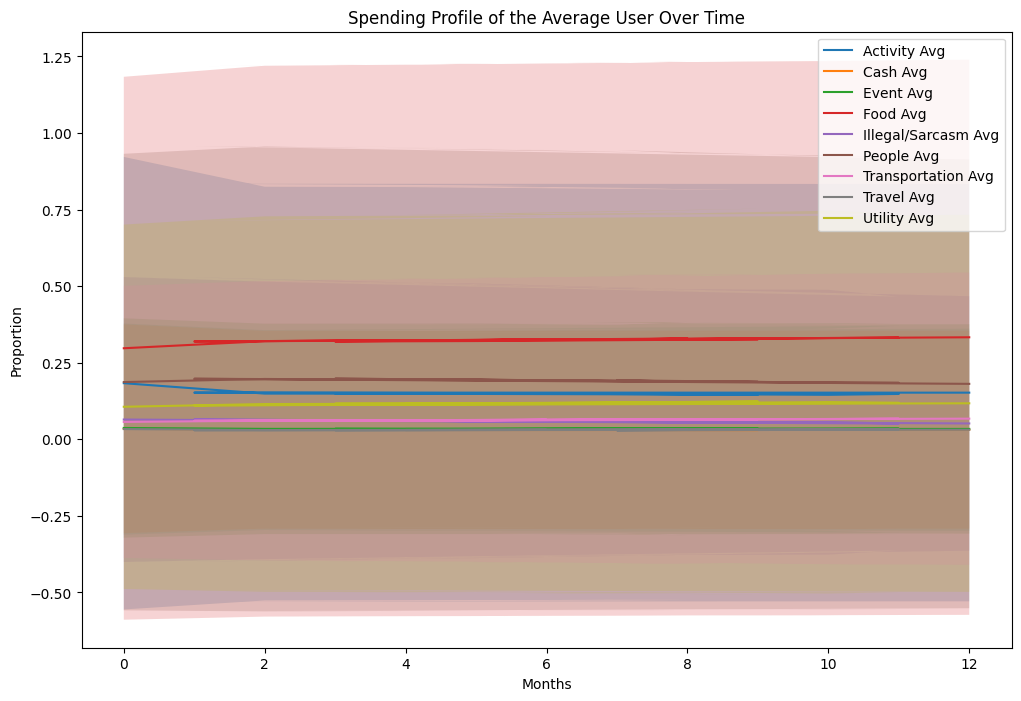

In [ ]:
import matplotlib.pyplot as plt

# Convert to Pandas for plotting
monthly_avg_stddev_pd = monthly_avg_stddev.toPandas()

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
months = monthly_avg_stddev_pd["month"]

for category in category_columns:
    avg_col = f"{category}_avg"
    stddev_col = f"{category}_stddev"

    ax.plot(months, monthly_avg_stddev_pd[avg_col], label=f"{category} Avg")
    ax.fill_between(months,
                    monthly_avg_stddev_pd[avg_col] - 2 * monthly_avg_stddev_pd[stddev_col],
                    monthly_avg_stddev_pd[avg_col] + 2 * monthly_avg_stddev_pd[stddev_col],
                    alpha=0.2)

ax.set_xlabel("Months")
ax.set_ylabel("Proportion")
ax.set_title("Spending Profile of the Average User Over Time")
ax.legend()
plt.show()

> #### __Observations:__  
The plot shows the spending profile of the average user over the first 12 months.
The Food Avg category seems to be consistently higher than the other categories.
Most categories remain relatively stable with slight fluctuations.
Confidence intervals are large, indicating significant variation in spending habits among users.
There is a clear indication that the average spending proportions do not stabilize completely but show a general trend.

---

### __2. Social Network Analytics__

#### 2.1 Find Friend and Friend of Friend

In [30]:
# import packages
import re
import pandas as pd
from google.colab import drive
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit, col, udf, explode, array_contains, split, size, array_union, when, collect_set
from pyspark.sql.types import ArrayType, StringType

In [31]:
# Load the dataset
venmo_df = spark.read.parquet(parquet_file_path, header=True, inferSchema=True)
venmo_df.show(20)

+--------+-------+----------------+-------------------+--------------------+-----------+--------------------+
|   user1|  user2|transaction_type|           datetime|         description|is_business|            story_id|
+--------+-------+----------------+-------------------+--------------------+-----------+--------------------+
| 1218774|1528945|         payment|2015-11-27 10:48:19|                Uber|      false|5657c473cd03c9af2...|
| 5109483|4782303|         payment|2015-06-17 11:37:04|              Costco|      false|5580f9702b64f70ab...|
| 4322148|3392963|         payment|2015-06-19 07:05:31|        Sweaty balls|      false|55835ccb1a624b14a...|
|  469894|1333620|          charge|2016-06-03 23:34:13|                  🎥|      false|5751b185cd03c9af2...|
| 2960727|3442373|         payment|2016-05-29 23:23:42|                   ⚡|      false|574b178ecd03c9af2...|
| 3977544|2709470|         payment|2016-09-29 22:12:07|          Chipotlaid|      false|57ed2f4723e064eac...|
| 3766386|4

In [32]:
# Step 1: Identify Direct Friends
# Union the user1 and user2 columns to find all unique user pairs
friends_df = venmo_df.select(col("user1").alias("user"), col("user2").alias("friend")).union(
    venmo_df.select(col("user2").alias("user"), col("user1").alias("friend"))
).distinct()

# Step 2: Identify Friends of Friends
# Self-join to find friends of friends
friends_of_friends_df = friends_df.alias("df1").join(
    friends_df.alias("df2"),
    col("df1.friend") == col("df2.user")
).select(
    col("df1.user"),
    col("df2.friend").alias("friend_of_friend")
).distinct()

# Collect friends and friends of friends for each user
user_friends_df = friends_df.groupBy("user").agg(
    collect_set("friend").alias("friends")
)

user_fof_df = friends_of_friends_df.groupBy("user").agg(
    collect_set("friend_of_friend").alias("friends_of_friends")
)

# Combine friends and friends of friends into a single DataFrame
user_network_df = user_friends_df.join(
    user_fof_df, on="user", how="left"
).select(
    col("user"),
    array_union(col("friends"), col("friends_of_friends")).alias("network")
)

# Sort the DataFrames by user in ascending order
user_friends_df = user_friends_df.orderBy("user")
user_fof_df = user_fof_df.orderBy("user")
user_network_df = user_network_df.orderBy("user")

In [33]:
# Show the result
user_network_df.show(truncate=False)

+----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [34]:
# Show the result for direct friends
user_friends_df.show(truncate=False)

# Show the result for friends of friends
user_fof_df.show(truncate=False)

+----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user|friends                                                                                                                                                                                                 |
+----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|2   |[220, 191142, 43]                                                                                                                                                                                       |
|3   |[52, 1079020, 263437, 43, 567957, 7854140, 2382556, 1204190]                                                                                                      

**Algorithm Description**
1.   Direct Friends Extraction:  
    *   Filter the transactions DataFrame to get all records where either user1 or user2 is equal to the given user ID.
    *   Create a new column friend to identify the friend in each transaction (i.e., if user1 is the user, user2 is the friend and vice versa).
    *   Select and distinct the friend column to get a unique list of direct friends.  
    
2.   Friends of Friends Extraction:
    *   Join the transactions DataFrame with the direct_friends DataFrame on user IDs (user1 or user2 matching the friend column).
    *   In the resulting DataFrame, create a new column fof to identify the friends of friends, ensuring that we exclude the original user and any direct friends.
    *   Filter out any null values in the fof column and select distinct values.  

3.   Combining Results:
    *   Union the direct friends and friends of friends DataFrames to get a combined list of all friends and friends of friends.
    *   Remove duplicates to ensure each friend or friend of friend appears only once.

**Computational Complexity**
1.   Direct Friends Extraction:  
    *   Filtering the DataFrame involves scanning all transactions, resulting in O(n) complexity, where n is the number of transactions.
    *   Selecting distinct values also involves O(n) complexity.
    
2.   Friends of Friends Extraction:
    *   The join operation involves combining two DataFrames, one of which has size proportional to the number of direct friends (let's call this k). The join complexity is approximately O(nk).
    *   The subsequent operations (like creating the fof column and filtering) have complexity O(n).  

3.   Combining Results:
    *   Union and distinct operations involve scanning both DataFrames, which is approximately O(n + nk).

Overall, the algorithm has a complexity of O(nk), where n is the number of transactions, and k is the number of direct friends.

#### 2.2 Calculate the social network metrics across a user’s lifetime in Venmo (from 0 up to 12 months)

##### i) Number of friends and number of friends of friends

In [35]:
from pyspark.sql.functions import col, min

# Extract the transaction dates for user1 and user2
user1_dates = venmo_df.select(col("user1").alias("user"), col("datetime").alias("transaction_date"))
user2_dates = venmo_df.select(col("user2").alias("user"), col("datetime").alias("transaction_date"))

# Union the DataFrames to combine dates
combined_dates = user1_dates.union(user2_dates)

# Group by user and find the minimum transaction date
first_transaction_df = combined_dates.groupBy("user").agg(
    min("transaction_date").alias("first_transaction_date")
)

# Sort the DataFrame by user in ascending order
first_transaction_df = first_transaction_df.orderBy("user")

# Show the result
first_transaction_df.show(truncate=False)

+----+----------------------+
|user|first_transaction_date|
+----+----------------------+
|2   |2012-11-23 06:03:42   |
|3   |2016-06-27 01:14:37   |
|4   |2012-12-03 03:35:53   |
|6   |2014-06-28 00:18:16   |
|8   |2015-08-11 02:08:47   |
|9   |2012-06-28 04:28:32   |
|10  |2012-11-25 09:20:39   |
|11  |2012-05-15 22:08:58   |
|12  |2012-09-01 03:40:16   |
|13  |2012-09-28 06:11:39   |
|16  |2014-07-12 04:20:53   |
|18  |2016-02-21 07:17:22   |
|19  |2012-05-26 02:19:04   |
|24  |2013-12-20 10:31:39   |
|28  |2014-05-22 11:25:51   |
|29  |2014-04-25 23:37:38   |
|31  |2013-05-19 11:19:15   |
|32  |2012-11-07 01:29:50   |
|34  |2014-07-21 23:31:20   |
|42  |2012-08-25 00:30:23   |
+----+----------------------+
only showing top 20 rows



In [36]:
from pyspark.sql.functions import col, min, expr, months_between, floor

# Rename columns for joining purposes
first_transaction_df_user1 = first_transaction_df.withColumnRenamed("user", "user1").withColumnRenamed("first_transaction_date", "user1_first_transaction_date")
first_transaction_df_user2 = first_transaction_df.withColumnRenamed("user", "user2").withColumnRenamed("first_transaction_date", "user2_first_transaction_date")

# Join the original DataFrame with the first transaction dates
venmo_df_joined = venmo_df.join(first_transaction_df_user1, on="user1").join(first_transaction_df_user2, on="user2")

# Filter the DataFrame based on the condition (within one year after the first transaction date)
filtered_venmo_df = venmo_df_joined.filter(
    (col("datetime") <= expr("user1_first_transaction_date + interval 1 year")) &
    (col("datetime") <= expr("user2_first_transaction_date + interval 1 year"))
)

# Calculate month_index for user1 and user2
filtered_venmo_df = filtered_venmo_df.withColumn(
    "user1_month_index", floor(months_between(col("datetime"), col("user1_first_transaction_date")))
).withColumn(
    "user2_month_index", floor(months_between(col("datetime"), col("user2_first_transaction_date")))
)

# Select relevant columns
filtered_venmo_df = filtered_venmo_df.select("user1", "user2", "transaction_type", "datetime", "description", "is_business", "story_id", "user1_month_index", "user2_month_index")

# Show the filtered result with month indices
filtered_venmo_df.show(truncate=False)

+-------+-----+----------------+-------------------+---------------------------------------------------------------+-----------+------------------------+-----------------+-----------------+
|user1  |user2|transaction_type|datetime           |description                                                    |is_business|story_id                |user1_month_index|user2_month_index|
+-------+-----+----------------+-------------------+---------------------------------------------------------------+-----------+------------------------+-----------------+-----------------+
|112    |12   |charge          |2012-09-01 03:40:16|for a little cabin in the woods.... and by a 78 foot-waterfall!|false      |50412130c5b30a09817e30c9|2                |0                |
|582796 |28   |payment         |2014-06-02 11:02:23|Nanking                                                        |false      |538bf74fd546b84342b0c6e3|8                |0                |
|192    |31   |payment         |2013-05-19 11:19:1

In [37]:
from pyspark.sql.functions import col, min, expr, months_between, floor, collect_set, explode, size, array_distinct

# Create two DataFrames for user1 and user2
user1_df = filtered_venmo_df.select(col("user1").alias("user"), col("user1_month_index").alias("month_index"), col("user2").alias("friend"))
user2_df = filtered_venmo_df.select(col("user2").alias("user"), col("user2_month_index").alias("month_index"), col("user1").alias("friend"))

# Union the DataFrames to combine user1 and user2 data
combined_df = user1_df.union(user2_df)

# Group by user and month_index to get distinct friends for each month
friends_df = combined_df.groupBy("user", "month_index").agg(
    array_distinct(collect_set("friend")).alias("friends")
)

# Self-join to find friends of friends
fof_df = friends_df.withColumn("friend", explode("friends")).join(
    combined_df.select(col("user").alias("friend_user"), col("friend").alias("fof"), col("month_index").alias("fof_month_index")),
    (col("friend") == col("friend_user")) & (col("month_index") == col("fof_month_index")),
    "left"
).groupBy("user", "month_index").agg(
    array_distinct(collect_set("fof")).alias("friends_of_friends")
)

# Combine friends and friends of friends into a single DataFrame
result_df = friends_df.join(fof_df, on=["user", "month_index"], how="left").select(
    col("user"),
    col("month_index"),
    col("friends"),
    col("friends_of_friends")
)

# Calculate the counts of friends and friends of friends
result_df = result_df.withColumn("friend_count", size("friends")).withColumn("fof_count", size("friends_of_friends"))

# Show the result
result_df.orderBy("user", "month_index").show(truncate=False)

+----+-----------+---------------------------+------------------+------------+---------+
|user|month_index|friends                    |friends_of_friends|friend_count|fof_count|
+----+-----------+---------------------------+------------------+------------+---------+
|2   |0          |[220]                      |[2]               |1           |1        |
|3   |3          |[1079020, 7854140, 2382556]|[]                |3           |0        |
|4   |0          |[122744, 125527]           |[4]               |2           |1        |
|4   |1          |[125755]                   |[]                |1           |0        |
|6   |0          |[676003]                   |[6]               |1           |1        |
|6   |9          |[4330489]                  |[]                |1           |0        |
|8   |0          |[900433]                   |[8]               |1           |1        |
|8   |1          |[900433]                   |[2734056, 8]      |1           |2        |
|8   |5          |[65

##### ii) Clustering coefficient of a user's network

In [38]:
from pyspark.sql.types import DoubleType

# Define a function to calculate the clustering coefficient
def calculate_clustering_coefficient(user, friends, friends_of_friends):
    if len(friends) < 2:
        return 0.0
    triangles = 0
    for i in range(len(friends)):
        for j in range(i + 1, len(friends)):
            if friends[j] in friends_of_friends:
                triangles += 1
    possible_triangles = len(friends) * (len(friends) - 1) / 2
    return triangles / possible_triangles if possible_triangles > 0 else 0.0

# Register the function as a UDF
from pyspark.sql.functions import udf
clustering_coefficient_udf = udf(calculate_clustering_coefficient, DoubleType())

# Apply the UDF to calculate clustering coefficient
result_with_clustering_df = result_df.withColumn(
    "clustering_coefficient",
    clustering_coefficient_udf(col("user"), col("friends"), col("friends_of_friends"))
)

# Show the final result
result_with_clustering_df.orderBy("user", "month_index").show(truncate=False)

+----+-----------+---------------------------+------------------+------------+---------+----------------------+
|user|month_index|friends                    |friends_of_friends|friend_count|fof_count|clustering_coefficient|
+----+-----------+---------------------------+------------------+------------+---------+----------------------+
|2   |0          |[220]                      |[2]               |1           |1        |0.0                   |
|3   |3          |[1079020, 7854140, 2382556]|[]                |3           |0        |0.0                   |
|4   |0          |[122744, 125527]           |[4]               |2           |1        |0.0                   |
|4   |1          |[125755]                   |[]                |1           |0        |0.0                   |
|6   |0          |[676003]                   |[6]               |1           |1        |0.0                   |
|6   |9          |[4330489]                  |[]                |1           |0        |0.0             

In [39]:
# Show the distinct clustering_coefficient values and count the number of unique values
distinct_clustering_coefficients = result_with_clustering_df.select("clustering_coefficient").distinct()
distinct_count = distinct_clustering_coefficients.count()

print(f"Total number of distinct clustering coefficients: {distinct_count}")

Total number of distinct clustering coefficients: 201


In [40]:
# Show the distinct clustering coefficient values
distinct_clustering_coefficients.show(truncate=False)

+----------------------+
|clustering_coefficient|
+----------------------+
|0.12727272727272726   |
|0.14035087719298245   |
|0.38181818181818183   |
|0.08333333333333333   |
|0.0                   |
|0.4666666666666667    |
|0.4090909090909091    |
|0.4722222222222222    |
|0.08791208791208792   |
|0.2                   |
|0.2222222222222222    |
|0.5357142857142857    |
|0.8181818181818182    |
|0.5454545454545454    |
|0.1794871794871795    |
|0.5833333333333334    |
|0.07142857142857142   |
|0.5818181818181818    |
|0.9333333333333333    |
|0.7                   |
+----------------------+
only showing top 20 rows



### __3. Predictive Analytics with MLlib__

#### 3.1 Preparation

In [41]:
# import packages
import re
import pandas as pd
from google.colab import drive
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit, col, udf, explode, array_contains, split, size, array_union
from pyspark.sql.types import ArrayType, StringType

In [42]:
from pyspark.sql.functions import year, month, day

# Path to the file
parquet_file_path = '/content/drive/Shared drives/423/HW5/VenmoSample.snappy.parquet'

# Read the Parquet file into a DataFrame
data = spark.read.parquet(parquet_file_path)

# Add year column
data = data.withColumn("year", year(data["datetime"]))
data = data.withColumn("month", month(data["datetime"]))
data = data.withColumn("day", day(data["datetime"]))
data.show(10)

+-------+-------+----------------+-------------------+---------------+-----------+--------------------+----+-----+---+
|  user1|  user2|transaction_type|           datetime|    description|is_business|            story_id|year|month|day|
+-------+-------+----------------+-------------------+---------------+-----------+--------------------+----+-----+---+
|1218774|1528945|         payment|2015-11-27 10:48:19|           Uber|      false|5657c473cd03c9af2...|2015|   11| 27|
|5109483|4782303|         payment|2015-06-17 11:37:04|         Costco|      false|5580f9702b64f70ab...|2015|    6| 17|
|4322148|3392963|         payment|2015-06-19 07:05:31|   Sweaty balls|      false|55835ccb1a624b14a...|2015|    6| 19|
| 469894|1333620|          charge|2016-06-03 23:34:13|             🎥|      false|5751b185cd03c9af2...|2016|    6|  3|
|2960727|3442373|         payment|2016-05-29 23:23:42|              ⚡|      false|574b178ecd03c9af2...|2016|    5| 29|
|3977544|2709470|         payment|2016-09-29 22:1

#### 3.2 Create dependent variable: Number of Transactions (from 0 to 12 month)

In [43]:
from pyspark.sql.functions import col, count, min, month, year, expr

# Step 1: Find the first transaction date for each user
first_transaction = data.groupBy("user1").agg(
    min("datetime").alias("first_transaction_date")
)

# Step 2: Calculate the end date for the first 12 months for each user
first_transaction = first_transaction.withColumn(
    "end_date", expr("add_months(first_transaction_date, 12)")
)

# Join to get the end date into the main dataset
data_with_end_date = data.join(first_transaction, "user1")

# Step 3: Filter transactions within the first 12 months of each user's first transaction
filtered_data = data_with_end_date.filter(
    (col("datetime") <= col("end_date")) &
    (col("datetime") >= col("first_transaction_date"))
)

# Step 4: Calculate the total number of transactions for each user in the first 12 months
total_transactions_first_12_months = filtered_data.groupBy("user1").agg(
    count("transaction_type").alias("total_transactions_12_months")
).orderBy("user1")

total_transactions_first_12_months.show(10)

+-----+----------------------------+
|user1|total_transactions_12_months|
+-----+----------------------------+
|    2|                           1|
|    3|                           6|
|    4|                           2|
|   10|                           7|
|   11|                           6|
|   12|                           4|
|   13|                           4|
|   16|                           3|
|   19|                           1|
|   28|                           1|
+-----+----------------------------+
only showing top 10 rows



#### 3.3 Define Recency and Frequency

In [44]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, min, max, count, avg, month, year, datediff, lag, when, expr, months_between

# Step 1: Find the first transaction date for each user
first_transaction = data.groupBy("user1").agg(
    min("datetime").alias("first_transaction_date")
)

# Step 2: Calculate the end date for the first 12 months for each user
first_transaction = first_transaction.withColumn(
    "end_date", expr("add_months(first_transaction_date, 12)")
)

# Join to get the first transaction date and end date into the main dataset
data_with_dates = data.join(first_transaction, "user1")

# Filter transactions within the first 12 months of each user's first transaction
filtered_data = data_with_dates.filter(
    (col("datetime") <= col("end_date")) &
    (col("datetime") >= col("first_transaction_date"))
)

# Add year and month columns for grouping
filtered_data = filtered_data.withColumn("year", year("datetime")).withColumn("month", month("datetime"))

# Step 3: Calculate monthly metrics for each user
monthly_metrics = filtered_data.groupBy("user1", "year", "month").agg(
    max("datetime").alias("last_transaction_date"),
    count("transaction_type").alias("monthly_count")
)

# Step 4: Use window function to get the previous transaction date
window_spec = Window.partitionBy("user1").orderBy("datetime")

# Add the previous transaction date to the dataset
data_with_prev_transaction = filtered_data.withColumn(
    "prev_transaction_date", lag("datetime").over(window_spec)
)

# Calculate monthly metrics again with previous transaction date included
monthly_metrics_with_prev = data_with_prev_transaction.groupBy("user1", "year", "month").agg(
    max("datetime").alias("last_transaction_date"),
    count("transaction_type").alias("monthly_count"),
    max("prev_transaction_date").alias("prev_transaction_date")
)

# Calculate recency based on previous transaction date, setting recency to 0 if there is no previous transaction
monthly_metrics_with_prev = monthly_metrics_with_prev.withColumn(
    "recency", when(col("prev_transaction_date").isNotNull(), datediff(col("last_transaction_date"), col("prev_transaction_date"))).otherwise(0)
).orderBy("user1","year","month")

# Rename the columns
monthly_metrics_with_prev = monthly_metrics_with_prev.withColumnRenamed("monthly_count", "frequency")

# Add first_transaction_date to the final dataset
monthly_metrics_with_prev = monthly_metrics_with_prev.join(first_transaction.select("user1", "first_transaction_date"), "user1")

# Calculate lifetime_point correctly
monthly_metrics_with_prev = monthly_metrics_with_prev.withColumn(
    "lifetime_point", ((year(col("last_transaction_date")) - year(col("first_transaction_date"))) * 12 +
                       (month(col("last_transaction_date")) - month(col("first_transaction_date"))))
).orderBy("user1","year","month")

monthly_metrics_with_prev.show(20)

+-----+----+-----+---------------------+---------+---------------------+-------+----------------------+--------------+
|user1|year|month|last_transaction_date|frequency|prev_transaction_date|recency|first_transaction_date|lifetime_point|
+-----+----+-----+---------------------+---------+---------------------+-------+----------------------+--------------+
|    2|2012|   11|  2012-11-23 06:03:42|        1|                 NULL|      0|   2012-11-23 06:03:42|             0|
|    3|2016|    9|  2016-09-22 15:30:09|        1|                 NULL|      0|   2016-09-22 15:30:09|             0|
|    3|2016|   10|  2016-10-09 03:36:13|        5|  2016-10-09 01:56:24|      0|   2016-09-22 15:30:09|             1|
|    4|2012|   12|  2012-12-15 05:51:12|        2|  2012-12-03 03:35:53|     12|   2012-12-03 03:35:53|             0|
|   10|2012|   11|  2012-11-25 09:20:39|        1|                 NULL|      0|   2012-11-25 09:20:39|             0|
|   10|2012|   12|  2012-12-31 12:44:12|        

#### 3.4 Regress recency and frequency on Y

In [45]:
# Join the two dataframes on user1
joined_data = total_transactions_first_12_months.join(monthly_metrics_with_prev, "user1")

# Select the required columns
final_data = joined_data.select("user1", "lifetime_point", "total_transactions_12_months", "frequency", "recency").orderBy("user1","lifetime_point")

# Show the result
final_data.show(10)

+-----+--------------+----------------------------+---------+-------+
|user1|lifetime_point|total_transactions_12_months|frequency|recency|
+-----+--------------+----------------------------+---------+-------+
|    2|             0|                           1|        1|      0|
|    3|             0|                           6|        1|      0|
|    3|             1|                           6|        5|      0|
|    4|             0|                           2|        2|     12|
|   10|             0|                           7|        1|      0|
|   10|             1|                           7|        2|      8|
|   10|             2|                           7|        1|     14|
|   10|             4|                           7|        2|      8|
|   10|             5|                           7|        1|     25|
|   11|             0|                           6|        1|      0|
+-----+--------------+----------------------------+---------+-------+
only showing top 10 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Dictionary to store MSE
mse_dict = {}

# Iterate through each lifetime point and calculate MSE
for lifetime_point in range(0, 13):
    df_lifetime = final_data.filter(col("lifetime_point") == lifetime_point)

    if df_lifetime.count() > 0:
        # Split the dataset
        train_data, test_data = df_lifetime.randomSplit([0.8, 0.2], seed=42)

        # Assemble feature vector
        assembler = VectorAssembler(inputCols=["frequency", "recency"], outputCol="features")
        train_data = assembler.transform(train_data)
        test_data = assembler.transform(test_data)

        # Linear regression model
        lr = LinearRegression(labelCol="total_transactions_12_months", featuresCol="features")
        lr_model = lr.fit(train_data)

        # Model evaluation
        train_summary = lr_model.summary
        test_results = lr_model.evaluate(test_data)

        # Record MSE
        mse_dict[lifetime_point] = test_results.meanSquaredError

# Convert to DataFrame for plotting
mse_df = pd.DataFrame(list(mse_dict.items()), columns=['lifetime_point', 'MSE'])

# Plot the chart
plt.figure(figsize=(10, 6))
plt.plot(mse_df['lifetime_point'], mse_df['MSE'], marker='o')
plt.xlabel('Lifetime Point (months)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Each Lifetime Point')
plt.grid(True)
plt.show()

#### 3.5 Add Variables from Text Analysis and Social Network Analysis

##### i) With Variables from Text Analysis

In [ ]:
# Perform left join
joined_data = final_data.join(user_monthly_profile, (final_data.user1 == user_monthly_profile.user1) &
 (final_data.lifetime_point == user_monthly_profile.month), how='left')
joined_data.show(truncate=False)

In [ ]:
# Dictionary to store MSE
mse_dict = {}

# Iterate through each lifetime point and calculate MSE
for lifetime_point in range(0, 13):
    df_lifetime = joined_data.filter(col("lifetime_point") == lifetime_point)

    if df_lifetime.count() > 0:
        # Split the dataset
        train_data, test_data = df_lifetime.randomSplit([0.8, 0.2], seed=42)

        # Assemble feature vector
        assembler = VectorAssembler(inputCols=["frequency", "recency", "Activity", "Cash", "Event", "Food",
                                               "Illegal/Sarcasm", "People", "Transportation", "Travel", "Utility"],
                                    outputCol="features")
        train_data = assembler.transform(train_data)
        test_data = assembler.transform(test_data)

        # Linear regression model
        lr = LinearRegression(labelCol="total_transactions_12_months", featuresCol="features")
        lr_model = lr.fit(train_data)

        # Model evaluation
        test_results = lr_model.evaluate(test_data)

        # Record MSE
        mse_dict[lifetime_point] = test_results.meanSquaredError

# Convert to DataFrame for plotting
mse_df = pd.DataFrame(list(mse_dict.items()), columns=['lifetime_point', 'MSE'])

# Plot the chart
plt.figure(figsize=(10, 6))
plt.plot(mse_df['lifetime_point'], mse_df['MSE'], marker='o')
plt.xlabel('Lifetime Point (months)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Each Lifetime Point with Spending Behavior Profile')
plt.grid(True)
plt.show()

##### ii) With Variables from Social Network Analysis

In [ ]:
# Perform left join and select necessary columns
joined_data = final_data.join(
    result_with_clustering_df,
    (final_data.user1 == result_with_clustering_df.user) & (final_data.lifetime_point == result_with_clustering_df.month_index),
    how='left'
).select(
    final_data["*"],
    result_with_clustering_df["friend_count"],
    result_with_clustering_df["fof_count"]
)

# Show the result
joined_data.show(truncate=False)

In [ ]:
# Dictionary to store MSE
mse_dict = {}

# Iterate through each lifetime point and calculate MSE
for lifetime_point in range(0, 13):
    df_lifetime = joined_data.filter(col("lifetime_point") == lifetime_point)

    if df_lifetime.count() > 0:
        # Split the dataset
        train_data, test_data = df_lifetime.randomSplit([0.8, 0.2], seed=42)

        # Assemble feature vector
        assembler = VectorAssembler(inputCols=["friend_count", "fof_count"], outputCol="features")
        train_data = assembler.transform(train_data)
        test_data = assembler.transform(test_data)

        # Linear regression model
        lr = LinearRegression(labelCol="total_transactions_12_months", featuresCol="features")
        lr_model = lr.fit(train_data)

        # Model evaluation
        test_results = lr_model.evaluate(test_data)

        # Record MSE
        mse_dict[lifetime_point] = test_results.meanSquaredError

# Convert to DataFrame for plotting
mse_df = pd.DataFrame(list(mse_dict.items()), columns=['lifetime_point', 'MSE'])

# Plot the chart
plt.figure(figsize=(10, 6))
plt.plot(mse_df['lifetime_point'], mse_df['MSE'], marker='o')
plt.xlabel('Lifetime Point (months)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Each Lifetime Point with Social Network Metrics')
plt.grid(True)
plt.show()

##### iii) With Variables from both Analysis

In [ ]:
# Perform left join of final_data and result_with_clustering_df
joined_data_temp = final_data.join(
    result_with_clustering_df,
    (final_data.user1 == result_with_clustering_df.user) & (final_data.lifetime_point == result_with_clustering_df.month_index),
    how='left'
).select(
    final_data["*"],
    result_with_clustering_df["friend_count"],
    result_with_clustering_df["fof_count"]
)

# Perform left join of the result with user_monthly_profile
joined_data = joined_data_temp.join(
    user_monthly_profile,
    (joined_data_temp.user1 == user_monthly_profile.user1) & (joined_data_temp.lifetime_point == user_monthly_profile.month),
    how='left'
).select(
    joined_data_temp["*"],
    user_monthly_profile["Activity"],
    user_monthly_profile["Cash"],
    user_monthly_profile["Event"],
    user_monthly_profile["Food"],
    user_monthly_profile["Illegal/Sarcasm"],
    user_monthly_profile["People"],
    user_monthly_profile["Transportation"],
    user_monthly_profile["Travel"],
    user_monthly_profile["Utility"]
)

# Show the result
joined_data.show(truncate=False)

In [ ]:
# Dictionary to store MSE
mse_dict = {}

# Iterate through each lifetime point and calculate MSE
for lifetime_point in range(0, 13):
    df_lifetime = joined_data.filter(col("lifetime_point") == lifetime_point)

    if df_lifetime.count() > 0:
        # Split the dataset
        train_data, test_data = df_lifetime.randomSplit([0.8, 0.2], seed=42)

        # Assemble feature vector
        assembler = VectorAssembler(inputCols=["friend_count", "fof_count", "Activity", "Cash", "Event", "Food",
                                               "Illegal/Sarcasm", "People", "Transportation", "Travel", "Utility"],
                                    outputCol="features")
        train_data = assembler.transform(train_data)
        test_data = assembler.transform(test_data)

        # Linear regression model
        lr = LinearRegression(labelCol="total_transactions_12_months", featuresCol="features")
        lr_model = lr.fit(train_data)

        # Model evaluation
        test_results = lr_model.evaluate(test_data)

        # Record MSE
        mse_dict[lifetime_point] = test_results.meanSquaredError

# Convert to DataFrame for plotting
mse_df = pd.DataFrame(list(mse_dict.items()), columns=['lifetime_point', 'MSE'])

# Plot the chart
plt.figure(figsize=(10, 6))
plt.plot(mse_df['lifetime_point'], mse_df['MSE'], marker='o')
plt.xlabel('Lifetime Point (months)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Each Lifetime Point with Social Network Metrics and Spending Behavior')
plt.grid(True)
plt.show()